![SNOTEL](Images/NWM.png)

# Retrieve and Analyze National Water Model Snow Data for a Watershed of Interest
Authors: Irene Garousi-Nejad (igarousi@cuahsi.org)
Last updated: March 4, 2025

**Introduction**: This notebook is divided into three main sections, each demonstrating how to retrieve snow water equivalent (SWE) data from different sources. This workflow is organized into six main sections. The first section ensures that the necessary Python packages and tools are installed and ready for analysis. The second section defines key parameters such as the watershed boundary and the locations of observation sites. The third section, Retrieve Observed Snow Data, focuses on acquiring observed SWE data from SNOTEL sites located within the Tuolumne River watershed. In the fourth section, Retrieve Modeled Snow Data, we access retrospective SWE data from National Water Model (NWM) version 3. The fifth section performs a direct comparison between modeled and observed SWE at individual SNOTEL sites. Finally, the sixth section evaluates how modeled and observed SWE compare when aggregated across the entire Tuolumne River watershed.

### 1. Prepare the Python Environment

Use the following command to ensure that all dependencies are installed in your environment. Note, these library versions have been pinned and tested for `Python 3.11.8`.

In [ ]:
!pip install -r requirements.txt

Import the libraries needed to run this notebook:

In [1]:
import os
import sys
import dask
import numpy
import glob
import pyproj
import pandas as pd
import xarray as xr
import time
import fsspec
import rioxarray
import hvplot.pandas
from supporting_scripts import nwm_utils
import hvplot.pandas
import holoviews as hv
import hvplot.xarray
hv.extension('bokeh')
import geopandas as gpd
import matplotlib.pyplot as plt
from dask.distributed import Client

import warnings
warnings.filterwarnings("ignore")

We'll use dask to parallelize our code.

In [2]:
# use a try accept loop so we only instantiate the client
# if it doesn't already exist.
try:
    print(client.dashboard_link)
except:    
    # The client should be customized to your workstation resources.
    client = Client(n_workers=6, threads_per_worker=1, memory_limit='2GB') 
    print(client.dashboard_link)

/user/igarousi/proxy/8787/status


### 2. Set Inputs

In [3]:
# Path to the watershed shapefile
watershed = "./TolumneRiver_18040009.shp"
basin = "./DonPedroDam_Upstream_Basin.shp"

# Path to NWM snow data
conus_bucket_url = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/ldasout.zarr'

# Start and end times of a water year (note that this code currently works for one water year)
StartDate = '2018-10-01'
EndDate = '2019-10-01'

# Path to save results (obs and mod stands for observation and modeled, respectively)
OBS_OutputFolder = './obs_outputs' 
MOD_OutputFolder = './mod_outputs'

### 3. Retrieve Observed Snow Data 

This code reads a GeoJSON file of all snow observation stations and filters them to include only stations in California with available CSV data. It also loads the watershed boundary shapefile (`TolumneRiver_18040009.shp`), converts it to the appropriate coordinate system, and merges all watershed polygons into a single MultiPolygon. Finally, it counts how many observation sites fall within this combined watershed boundary, providing the number of sites located inside the study area.

In [4]:
# Create geodataframe of all stations
all_stations_gdf = gpd.read_file('https://raw.githubusercontent.com/egagli/snotel_ccss_stations/main/all_stations.geojson').set_index('code')
all_stations_gdf = all_stations_gdf[all_stations_gdf['csvData']==True]
filtered_all_stations_gdf = all_stations_gdf[all_stations_gdf.state.str.contains('California')]  

# Extract the bounding box coordinates of a watershed
watershed_gdf = gpd.read_file(watershed).to_crs(epsg=4326)

# Combine all polygons into a single MultiPolygon
watershed_union = watershed_gdf.geometry.unary_union

# Use the polygon geometry to select snotel sites that are within the domain
gdf_in_bbox = filtered_all_stations_gdf[filtered_all_stations_gdf.geometry.within(watershed_union)]
gdf_in_bbox.reset_index(inplace=True)
print(f'There are {len(gdf_in_bbox)} sites from', ', '.join(set(gdf_in_bbox.network)), 'network(s) within the watershed.')


There are 8 sites from CCSS network(s) within the watershed.


Plot these sites on a map. Then, hover over the pins to see the site names.

In [5]:
m = nwm_utils.plot_sites_within_domain(gdf_in_bbox, watershed_gdf, zoom_start=9)
m

Check the start and end date of available data for these sites.

In [6]:
for i in gdf_in_bbox.index:
    print('Site ', gdf_in_bbox.iloc[i].code, ":", gdf_in_bbox.iloc[i].beginDate, "-", gdf_in_bbox.iloc[i].endDate)

Site  WHW : 2007-10-25 00:00:00 - 2025-03-03 00:00:00
Site  TUM : 2004-10-01 00:00:00 - 2025-03-03 00:00:00
Site  KIB : 2005-10-01 00:00:00 - 2025-03-03 00:00:00
Site  TES : 2004-10-01 00:00:00 - 2025-03-02 00:00:00
Site  DAN : 2004-10-01 00:00:00 - 2025-03-03 00:00:00
Site  HRS : 2004-10-01 00:00:00 - 2025-03-03 00:00:00
Site  PDS : 2005-10-01 00:00:00 - 2025-03-03 00:00:00
Site  SLI : 2005-10-01 00:00:00 - 2025-03-03 00:00:00


The following uses the `nwm_utils.py` script to download observed data for the sites within the domain. Since all the sites are from the (California Cooperative Snow Survey) CCSS network, we use the `getCCSSData` function from the module to get data. 

<div style="background-color:#f5f5f5; padding:10px; border-left: 5px solid #007acc;">
<h4>📖 Did you know?</h4>
<p>The California Cooperative Snow Surveys (CCSS) program, managed primarily by the California Department of Water Resources (DWR), monitors snowpack across key California watersheds to estimate annual water supply. Most CCSS sites are manual snow courses, where surveyors physically measure snow depth and snow water equivalent (SWE) several times a year, though some sites have been upgraded with automated sensors. In contrast, SNOTEL sites, managed by the USDA Natural Resources Conservation Service (NRCS), are fully automated and collect data continuously across the western United States, including California. While CCSS primarily supports water supply forecasting, SNOTEL supports both water supply forecasting and climate monitoring. </p>
</div>

In [7]:
# Create a folder to save results
isExist = os.path.exists(OBS_OutputFolder)
if isExist == True:
    exit
else:
    os.mkdir(OBS_OutputFolder)

In [8]:
for i in gdf_in_bbox.index:
    nwm_utils.getCCSSData(gdf_in_bbox.name[i], gdf_in_bbox.code[i], StartDate, EndDate, OBS_OutputFolder)

RangeIndex(start=0, stop=1, step=1)
✅ Retrieved data for White Wolf, WHW in 0.53 seconds

RangeIndex(start=0, stop=1, step=1)
✅ Retrieved data for Tuolumne Meadows, TUM in 0.35 seconds

RangeIndex(start=0, stop=1, step=1)
✅ Retrieved data for Lower Kibbie Ridge, KIB in 0.35 seconds

RangeIndex(start=0, stop=1, step=1)
✅ Retrieved data for Tioga Pass Entry Station, TES in 0.48 seconds

RangeIndex(start=0, stop=1, step=1)
✅ Retrieved data for Dana Meadows, DAN in 0.33 seconds

RangeIndex(start=0, stop=1, step=1)
✅ Retrieved data for Horse Meadow, HRS in 0.34 seconds

RangeIndex(start=0, stop=1, step=1)
✅ Retrieved data for Paradise Meadow, PDS in 0.34 seconds

RangeIndex(start=0, stop=1, step=1)
✅ Retrieved data for Slide Canyon, SLI in 0.35 seconds



### 4. Retrieve Modeled Snow Data

NOAA shares inputs and outputs to the National Water Model retrospective simulations version 3 at <a href="https://noaa-nwm-retrospective-3-0-pds.s3.amazonaws.com/index.html" style="color: blue; background-color: snow;">https://noaa-nwm-retrospective-3-0-pds.s3.amazonaws.com/index.html</a>. The following code uses `fsspec` and `xarray` Python libraries to load the Zarr metadata of snow outputs (**ldasout.zarr**) into memory. Once the code is executed, you can see the wall time, which includes time spent waiting for I/O operations, such as reading data from a remote server. In our case, it took about 12 seconds to load the metadata into memory. Set up `Dask`, a parallel computing library, to enable performing operations on large datasets that don't fit into memory by breaking them into smaller, manageable pieces called chunks.

In [9]:
# Load the Continental Scale NWM Versino 3 Retrospective Data
%time ds = ds = xr.open_zarr(fsspec.get_mapper(conus_bucket_url, anon=True), consolidated=True)

CPU times: user 3.31 s, sys: 286 ms, total: 3.6 s
Wall time: 11.2 s


The following code retrieves NWM data for each SNOTEL site within our watershed. For each site, it first converts latitude and longitude of the site to the projected coordinates used by the NWM. Then, it extracts the NWM data SWE for the site and the period of interest, saving the result as a DataFrame. Since NWM timestamps are in UTC, the DataFrame is converted to the local time zone to match SNOTEL observations for later comparison purposes. To fairly compare with SNOTEL, which reports SWE once daily at the start of the local day, the data is grouped by date, and the earliest record of each day is selected. Finally, the processed data is saved as a CSV file for each site.

In [10]:
# Create a folder to save results
isExist = os.path.exists(MOD_OutputFolder)
if isExist == True:
    exit
else:
    os.mkdir(MOD_OutputFolder)

In [11]:
# Retrieve data for the location of snotel sites
input_crs = 'EPSG:4269'
output_crs = pyproj.CRS(ds.crs.esri_pe_string) 

for i in range(0, gdf_in_bbox.shape[0]):
    site_name = gdf_in_bbox.iloc[i]["name"]
    print(f'[{i+1}/{len(gdf_in_bbox)}] Retrieving data for site: {site_name}')
    snotel_y, snotel_x = nwm_utils.convert_latlon_to_yx(gdf_in_bbox.iloc[i].latitude, 
                                                      gdf_in_bbox.iloc[i].longitude, 
                                                        input_crs, ds, output_crs)
    
    dl_start_time = time.time()
    ds_subset = ds[['SNEQV']].sel(y=snotel_y, x=snotel_x, method='nearest'
                                 ).sel(time=slice(StartDate, EndDate)).compute()
    dl_elapsed = time.time() - dl_start_time
    print(f'✅ Retrieved data for {site_name} in {dl_elapsed:.2f} seconds\n')
    
    df = ds_subset.to_dataframe()
    df=df.drop(columns=['x', 'y'])
    df.reset_index(inplace=True)
    df["time"] = pd.to_datetime(df["time"])
    df.rename(columns={df.columns[0]:'Date', df.columns[1]:'NWM_SWE_meters'}, inplace=True)
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(lambda x: pd.to_numeric(x)/1000)  # convert mm to m   

    # convert utc to local time zone
    df_local = nwm_utils.convert_utc_to_local(gdf_in_bbox.iloc[i].state, df)   
    
    # groupby the data and select the first item from each group 
    df_local.index = pd.to_datetime(df_local['Date_Local'])
    df_local = df_local.groupby(pd.Grouper(freq='D')).first()

    # save
    df_local.to_csv(f'./{MOD_OutputFolder}/df_{gdf_in_bbox.iloc[i].code}_{gdf_in_bbox.iloc[i].state}_NWM.csv', index=False)

[1/8] Retrieving data for site: White Wolf
✅ Retrieved data for White Wolf in 2.54 seconds

[2/8] Retrieving data for site: Tuolumne Meadows
✅ Retrieved data for Tuolumne Meadows in 0.70 seconds

[3/8] Retrieving data for site: Lower Kibbie Ridge
✅ Retrieved data for Lower Kibbie Ridge in 0.78 seconds

[4/8] Retrieving data for site: Tioga Pass Entry Station
✅ Retrieved data for Tioga Pass Entry Station in 0.74 seconds

[5/8] Retrieving data for site: Dana Meadows
✅ Retrieved data for Dana Meadows in 0.70 seconds

[6/8] Retrieving data for site: Horse Meadow
✅ Retrieved data for Horse Meadow in 0.68 seconds

[7/8] Retrieving data for site: Paradise Meadow
✅ Retrieved data for Paradise Meadow in 0.72 seconds

[8/8] Retrieving data for site: Slide Canyon
✅ Retrieved data for Slide Canyon in 0.74 seconds



### 5. Compare modeled SWE with observed at a site

You should already have the CSV data for both observed and modeled flows in your working environment. The section below reads data and then for a selected gage compares model performance using various metrics.

In [12]:
obs = glob.glob(os.path.join('obs_outputs', '*.csv'))
mod = glob.glob(os.path.join('mod_outputs', '*.csv'))

# call the function from the nwm_utils library
combined_df = nwm_utils.combine(obs, mod, StartDate, EndDate)

In [13]:
combined_df.columns

Index(['CCSS_HRS_swe_m', 'CCSS_SLI_swe_m', 'CCSS_DAN_swe_m', 'CCSS_PDS_swe_m',
       'CCSS_TUM_swe_m', 'CCSS_WHW_swe_m', 'CCSS_TES_swe_m', 'CCSS_KIB_swe_m',
       'NWM_HRS_swe_m', 'NWM_KIB_swe_m', 'NWM_TES_swe_m', 'NWM_SLI_swe_m',
       'NWM_PDS_swe_m', 'NWM_DAN_swe_m', 'NWM_WHW_swe_m', 'NWM_TUM_swe_m'],
      dtype='object')

Review the sites within the watershed from the interactive map above and click on the markers to view the site name and code. Once you’ve identified the site of interest, enter its site code in the next code cell.

In [14]:
# choose a gage of interest within the watershed
my_site_code = 'HRS'

Plot both datasets.

In [15]:
nwm_utils.comparison_plots(combined_df, f'CCSS_{my_site_code}_swe_m', f'NWM_{my_site_code}_swe_m')

:Layout
   .Overlay.I  :Overlay
      .Curve.Observed_SWE :Curve   [index]   (CCSS_HRS_swe_m)
      .Curve.Modeled_SWE  :Curve   [index]   (NWM_HRS_swe_m)
   .Overlay.II :Overlay
      .Scatter.I              :Scatter   [CCSS_HRS_swe_m]   (NWM_HRS_swe_m,index)
      .Curve.A_1_colon_1_Line :Curve   [x]   (y)

Let's customize the scatter plot by allowing you to highlight specific months with a distinct color. The selected months will appear in one color, while all other months will appear in a different color. This customization helps reveal whether there are **seasonal patterns** in the relationship between observed and modeled SWE. In fact, it allows us to see if the model performs differently during key periods, such as the <span style="color: teal;">**accumulation**</span> phase or the <span style="color: tomato;">**melt**</span> period. Identifying these patterns is important for diagnosing the model’s strengths and limitations during different parts of the snow season, which is critical for understanding how well the model represents key processes driving snowpack evolution.

You can change the list of months to highlight (for example, 10 for October or 1 for January) to see how highlighting different parts of the year changes the appearance and interpretation of the scatter plot.

In [16]:
combined_df['month'] = combined_df.index.month

plot = nwm_utils.plot_custom_scatter(combined_df, my_site_code, highlight_months=[10, 11, 12, 1])
plot

:Overlay
   .Scatter.I              :Scatter   [CCSS_HRS_swe_m]   (NWM_HRS_swe_m,color,index,month)
   .Curve.A_1_colon_1_Line :Curve   [x]   (y)

Compute statistics

In [17]:
nwm_utils.compute_stats(combined_df, f'CCSS_{my_site_code}_swe_m', f'NWM_{my_site_code}_swe_m')

Mean   Median Standard Deviation  \
observed                         0.739806    0.381           0.782846   
modeled                          0.478396  0.24725           0.554199   
                                                                        
Pearson Correlation              0.956064                               
Spearman Correlation             0.957418                               
Bias (Modeled - Observed)        -0.26141                               
Nash-Sutcliffe Efficiency (NSE)  0.740677                               
Kling-Gupta Efficiency (KGE)     0.539465                               

                                 Variance  Min     Max  
observed                         0.612848  0.0  2.1209  
modeled                          0.307136  0.0  1.5498  
                                                        
Pearson Correlation                                     
Spearman Correlation                                    
Bias (Modeled - Observed)                               
Nash-Sutcliffe Efficiency (NSE)                         
Kling-Gupta Efficiency (KGE)

:::{admonition}Reflect
You now have several performance metrics: Bias, Pearson Correlation, Spearman Correlation, NSE, and KGE. If you had to pick just one metric to summarize model performance, which would you choose—and why? As you review the results, compare the peak flow amounts and the timing of snowmelt onset. Do you see any significant differences? Which dataset indicates an earlier melt?
:::


Pearson and Spearman correlations are both close to 1, suggesting a strong relationship between observed and modeled SWE. As shown on the timeseries plot, this strong correlation alone does not indicate a "good" model. For example, it does not guarantee accurate timing of key events, such as peak SWE or melt onset. Let's compare these as well. The following code uses `report_max_dates_and_values` function to identify the peak SWE value and the date it occurs for both the observed (CCSS) and modeled (NWM) datasets. 

In [18]:
summary_table = nwm_utils.report_max_dates_and_values(combined_df, f'CCSS_{my_site_code}_swe_m', f'NWM_{my_site_code}_swe_m')
summary_table

Data Source  Peak SWE (m) Date of Maximum
0  CCSS_HRS_swe_m        2.1209      2019-04-20
1   NWM_HRS_swe_m        1.5498      2019-04-03

:::{admonition} Reflect
What is the modeled SWE on the date where the observed peak SWE occurs? You can use the following code to find the answer.

```python
# Find date of the peak SWE from observed data
date_obs_max = combined_df['CCSS_HRS_swe_m'].idxmax()

# Get corresponding value of modeled data on that date
value_mod_at_max_obs = combined_df.loc[date_obs_max, 'NWM_HRS_swe_m']


Compare the average melt rate over the full melt period. 

The following function computes the melt period length by identifying the first date after the peak SWE when SWE drops to zero and remains at zero for at least (`min_zero_days`) consecutive days. This is used to define the end of the melt period. Finally, the function calculates the average melt rate, which represents the rate at which snow disappeared, expressed in meters per day, over the full melt period.

In [19]:
observed_melt_period = nwm_utils.compute_melt_period(combined_df[f'CCSS_{my_site_code}_swe_m'])
observed_melt_period

{'peak_date': Timestamp('2019-04-20 00:00:00'),
 'peak_swe_m': 2.1209,
 'melt_end_date': Timestamp('2019-07-16 00:00:00'),
 'melt_period_days': 87,
 'melt_rate_m/d': 0.024378160919540228}

In [20]:
modeled_melt_period = nwm_utils.compute_melt_period(combined_df[f'NWM_{my_site_code}_swe_m'])
modeled_melt_period

{'peak_date': Timestamp('2019-04-03 00:00:00'),
 'peak_swe_m': 1.5498000230938196,
 'melt_end_date': Timestamp('2019-06-30 00:00:00'),
 'melt_period_days': 88,
 'melt_rate_m/d': 0.017611363898793406}

### 6. Compare modeled SWE with observed over the entire watershed

In this section, we take a deeper dive into analyzing the NWM snow data across the entire Tuolumne River watershed. To do this, we need to clip the gridded dataset to the watershed boundary, enabling us to compute spatial averages over the region. To begin, we will create a single geometry for the watershed by dissolving all HUC8-level basins within it.

In [21]:
watershed_huc8 = watershed_gdf.dissolve(by='HUC_8')

Similar to Section 4, we first ensure that the NWM data is loaded and that the domain of interest uses the same coordinate reference system (CRS) as the NWM dataset. This is required when clipping the dataset using `rioxarray`'s clip method later.

In [22]:
%time ds = ds = xr.open_zarr(fsspec.get_mapper(conus_bucket_url, anon=True), consolidated=True)
ds.rio.set_crs(ds.crs.attrs['esri_pe_string'])
ds.rio.write_crs(inplace=True);
shp = watershed_huc8.to_crs(ds.rio.crs)

CPU times: user 2.06 s, sys: 115 ms, total: 2.17 s
Wall time: 8.82 s


Let's clip the gridded data to the extent of this watershed. This can be done using `rioxarray`'s "clip" method.

In [23]:
# clip the data
ds_clip = ds.rio.clip(
         shp.geometry.values,
         shp.crs,
         all_touched=True,   # select all grid cells that touch the vector boundary
         drop=True,          # drop anything that is outside the clipped region
         invert=False,
         from_disk=True).sel(time=slice(StartDate, EndDate))

Preview the data at a specific point in time by defining an **exact date and time** (e.g., '2019-02-01T00:00'), an **index** (e.g., 1000, referring to the 1000th time step in the data array), a **year** (e.g., '2019'), or a **month** (e.g., '2019-02'). Specifying a year or month allows you to use a time slider widget to explore changes over time. We’ll use `hvplot` and `Holoviews` Python packages to create a more informative plot that displays both the gridded data and the vector data. One important note: for hvplot to visualize gridded data correctly on a map, all data must be in a **geographic coordinate system** (e.g., EPSG:4326). Note that it may take a while for the following task (map visualization) to be completed.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
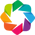

:DynamicMap   [time]
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)

In [25]:
nwm_utils.plot_grid_vector_data(ds_clip, 'SNEQV', '2019', watershed_huc8, gdf_in_bbox)

Go ahead and play around with the time slider above to see how SWE changes over time across the watershed. 

:::{admonition} Explore
Using the zoom options in the hvplot toolbar, can you comment on the possible reasons for the missing values or pixels visible on the map?  


Compute the spatial average of SWE across the entire region. First, we calculate the spatial average for both the modeled and observed datasets. Then, we create a DataFrame that combines the basin-averaged modeled data with the observed data for direct comparison.

In [26]:
# Modeled data
ds_clip_swe_mean = ds_clip.SNEQV.mean(dim=(['x', 'y'])).sel(time=slice(StartDate, EndDate)).compute()
df_mod_swe_mean = nwm_utils.prep_nwm_swe_dataframe(ds_clip_swe_mean, gdf_in_bbox.iloc[0].state)

# Observed data
df_obs_swe_mean = nwm_utils.compute_spatial_agg_from_obs('./obs_outputs', 'mean')
df_obs_swe_mean['Date'] = pd.to_datetime(df_obs_swe_mean['Date']).dt.date
df_mod_swe_mean['Date_Local'] = pd.to_datetime(df_mod_swe_mean['Date_Local']).dt.date

# Combine
combined_df_mean = pd.merge(
    df_mod_swe_mean, df_obs_swe_mean, 
    left_on='Date_Local',  
    right_on='Date',       
    how='inner'  
)
combined_df_mean = combined_df_mean[['Date_Local', 'Snow Water Equivalent (m) Start of Day Values', 'NWM_SWE_meters']]
combined_df_mean.index = pd.to_datetime(combined_df_mean['Date_Local'])

# Plot
nwm_utils.comparison_plots(combined_df_mean, 'Snow Water Equivalent (m) Start of Day Values', 'NWM_SWE_meters')

:Layout
   .Overlay.I  :Overlay
      .Curve.Observed_SWE :Curve   [Date_Local]   (Snow Water Equivalent (m) Start of Day Values)
      .Curve.Modeled_SWE  :Curve   [Date_Local]   (NWM_SWE_meters)
   .Overlay.II :Overlay
      .Scatter.I              :Scatter   [Snow Water Equivalent (m) Start of Day Values]   (NWM_SWE_meters)
      .Curve.A_1_colon_1_Line :Curve   [x]   (y)

In [27]:
# Stats
nwm_utils.compute_stats(combined_df_mean, 'Snow Water Equivalent (m) Start of Day Values', 'NWM_SWE_meters')

Mean    Median Standard Deviation  \
observed                         0.423981  0.221524           0.473506   
modeled                          0.138785  0.075134           0.156408   
                                                                         
Pearson Correlation               0.98967                                
Spearman Correlation             0.972797                                
Bias (Modeled - Observed)       -0.285196                                
Nash-Sutcliffe Efficiency (NSE)  0.180936                                
Kling-Gupta Efficiency (KGE)     0.050761                                

                                 Variance  Min       Max  
observed                         0.224208  0.0  1.324429  
modeled                          0.024463  0.0  0.440114  
                                                          
Pearson Correlation                                       
Spearman Correlation                                      
Bias (Modeled - Observed)                                 
Nash-Sutcliffe Efficiency (NSE)                           
Kling-Gupta Efficiency (KGE)

:::{admonition}Reflect
What could be the potential sources of discrepancies between the spatially averaged SWE from the modeled and observed datasets within this catchment? How could you generate more reliable or informative statistics? How do you think the presence of SWE values equal to zero across large areas of the gridded dataset (as seen in the map above) — particularly when this pattern is consistent across the wayter year — might impact the spatially averaged SWE values? How could this influence your interpretation?
:::

#### Don Pedro Reservoir Basin

Repeat the steps above, but this time focus on a smaller domain. For example, the upstream catchments of the Don Pedro Reservoir (`DonPedroDam_Upstream_Basin.shp`). This allows us to examine the impact of excluding areas where SWE is zero for the majority of days within a water year. Could this approach improve the statistical comparison between modeled and observed SWE? 

:::{admonition} Note
The following steps assume that the necessary code cells from the previous sections have already been executed.

```python
%time ds = xr.open_zarr(fsspec.get_mapper(conus_bucket_url, anon=True), consolidated=True)
ds.rio.set_crs(ds.crs.attrs['esri_pe_string'])
ds.rio.write_crs(inplace=True);










In [28]:
donpedro_gdf = gpd.read_file('./DonPedroDam_Upstream_Basin.shp').to_crs(epsg=4326)
shp = donpedro_gdf.to_crs(ds.rio.crs)
ds_clip_donpedro = ds.rio.clip(
         shp.geometry.values,
         shp.crs,
         all_touched=True,   
         drop=True,         
         invert=False,
         from_disk=True).sel(time=slice(StartDate, EndDate))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
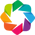

:DynamicMap   [time]
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)

In [29]:
nwm_utils.plot_grid_vector_data(ds_clip_donpedro, 'SNEQV', '2019', donpedro_gdf, gdf_in_bbox)

In [30]:
# Modeled data
ds_clip_swe_mean = ds_clip_donpedro.SNEQV.mean(dim=(['x', 'y'])).sel(time=slice(StartDate, EndDate)).compute()
df_mod_swe_mean = nwm_utils.prep_nwm_swe_dataframe(ds_clip_swe_mean, gdf_in_bbox.iloc[0].state)

# Observed data
df_obs_swe_mean = nwm_utils.compute_spatial_agg_from_obs('./obs_outputs', 'mean')
df_obs_swe_mean['Date'] = pd.to_datetime(df_obs_swe_mean['Date']).dt.date
df_mod_swe_mean['Date_Local'] = pd.to_datetime(df_mod_swe_mean['Date_Local']).dt.date

# Combine with the observed data
combined_df_mean = pd.merge(
    df_mod_swe_mean, df_obs_swe_mean, 
    left_on='Date_Local',  
    right_on='Date',       
    how='inner'  
)
combined_df_mean = combined_df_mean[['Date_Local', 'Snow Water Equivalent (m) Start of Day Values', 'NWM_SWE_meters']]
combined_df_mean.index = pd.to_datetime(combined_df_mean['Date_Local'])

# Plot
nwm_utils.comparison_plots(combined_df_mean, 'Snow Water Equivalent (m) Start of Day Values', 'NWM_SWE_meters')

:Layout
   .Overlay.I  :Overlay
      .Curve.Observed_SWE :Curve   [Date_Local]   (Snow Water Equivalent (m) Start of Day Values)
      .Curve.Modeled_SWE  :Curve   [Date_Local]   (NWM_SWE_meters)
   .Overlay.II :Overlay
      .Scatter.I              :Scatter   [Snow Water Equivalent (m) Start of Day Values]   (NWM_SWE_meters)
      .Curve.A_1_colon_1_Line :Curve   [x]   (y)

In [31]:
# Stats
nwm_utils.compute_stats(combined_df_mean, 'Snow Water Equivalent (m) Start of Day Values', 'NWM_SWE_meters')

Mean    Median Standard Deviation  \
observed                         0.423981  0.221524           0.473506   
modeled                          0.205815  0.111479           0.231931   
                                                                         
Pearson Correlation              0.989776                                
Spearman Correlation             0.972815                                
Bias (Modeled - Observed)       -0.218165                                
Nash-Sutcliffe Efficiency (NSE)  0.516831                                
Kling-Gupta Efficiency (KGE)     0.275316                                

                                 Variance  Min       Max  
observed                         0.224208  0.0  1.324429  
modeled                          0.053792  0.0  0.652939  
                                                          
Pearson Correlation                                       
Spearman Correlation                                      
Bias (Modeled - Observed)                                 
Nash-Sutcliffe Efficiency (NSE)                           
Kling-Gupta Efficiency (KGE)

Visualize both the temporal and spatial variability of modeled SWE across the domain. To achieve this, we first create a subset of the modeled data by selecting only the first time step of each month from the simulated SWE dataset. To improve processing efficiency, we chunk the dataset along the time dimension, allowing faster access to individual time slices. We then apply a time filter and compute each selected slice individually to avoid excessive memory use. Finally, we combine the computed slices back into a single dataset for analysis and visualization.

In [ ]:
# Check the current chunks
ds_clip_donpedro.chunks

In [ ]:
# Rechunck
ds_clip_donpedro = ds_clip_donpedro.chunk({'time': 1})
ds_clip_donpedro.chunks

**Note**: The following code may take several minutes to run.

In [34]:
%%time 

# Apply time filter
mask = (ds_clip_donpedro.time.dt.is_month_start) & (ds_clip_donpedro.time.dt.hour == 0)

# Compute in smaller pieces
selected_times = ds_clip_donpedro.time[mask]
parts = []
for t in selected_times.values:
    part = ds_clip_donpedro.sel(time=t).compute()  # One slice at a time
    parts.append(part)

# Combine the pieces
ds_monthly_start = xr.concat(parts, dim='time')

CPU times: user 32.7 s, sys: 2.75 s, total: 35.5 s
Wall time: 2min 8s


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
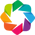

:Layout
   .Overlay.I    :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)
   .Overlay.II   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)
   .Overlay.III  :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)
   .Overlay.IV   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)
   .Overlay.V    :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)
   .Overlay.VI   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)
   .Overlay.VII  :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)
   .Overlay.VIII :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)
   .Overlay.IX   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)
   .Overlay.X    :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)
   .Overlay.XI   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)
   .Overlay.XII  :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)
   .Overlay.XIII :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Image.I    :Image   [longitude,latitude]   (SNEQV)
      .Polygons.I :Polygons   [Longitude,Latitude]
      .Points.I   :Points   [longitude,latitude]   (name)

In [35]:
nwm_utils.plot_grid_vector_monthly_data(ds_monthly_start, 'SNEQV', donpedro_gdf, gdf_in_bbox)

:::{admonition}Reflect
In the plot above, you can see that in both accumulation and melt periods (e.g., Feb-Jun), snow was present in areas not covered by the existing observation points. How would having more observation points distributed across these snow-covered areas affect the basin-average SWE from observations, as calculated and plotted previously (`combined_df_mean`). How could this change influence the bias, Nash-Sutcliffe Efficiency (NSE), and other statistical comparisons between modeled and observed SWE? And, how might improving the capture of spatial variability in SWE affect forecasts under future climate conditions?
:::